# Work capacity
Charles Simpson, June 2021

* This project is motivated by new results in physiology.
* We now have more accurate and applicable measurements of how people self pace their work in response to heat stress. (doi.org/10.1007/s00484-021-02105-0)
* In this project we will use CMIP6 data to estimate future occupational heat stress, and the effect on work pace.
* There are caveats,.


Ideas:
* Apply a mean+std bias correction for monthly (average daily max?) data.
* Do the global calculation with monthly data for one model.
* Then bring in the MIRCA2k crop data. Select the planting, growing, and harvesting seasons. Just do a few staples.
* Do population weighting with static population.(easy)
* Extend to extra models.
* Then extend to higher time resolution.
* What plots/tables do we want?
        * Absolute and change by country in year X, scenario X
        * Absolute and change by crop season in year X, scenario X

In [22]:
# General setup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-colorblind")
ABSOLUTE_ZERO = 273.15

In [2]:
def utci_to_pwc(utci):
    return 100 / (1 + (45.08 / utci) ** -4.78)

In [3]:
def valid_utci_to_pwc(utci):
    return utci_to_pwc(utci).where(utci > 15, 100).where(utci < 63, 0)

Text(0, 0.5, 'PWC (%)')

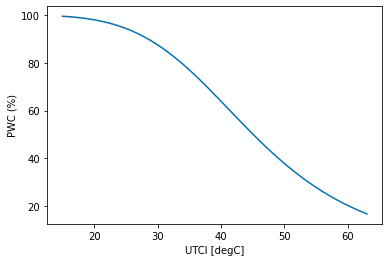

In [4]:
x = np.linspace(15, 63)
plt.plot(x, utci_to_pwc(x))
plt.xlabel("UTCI [degC]")
plt.ylabel("PWC (%)")

## Step 1: ERA-HEAT

In [15]:
import xarray as xr
from pathlib import Path

In [94]:
all_e5h_files = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/era5-heat_1deg/"
).glob("*nc")
first_e5h_file = list(
    Path("/gws/pw/j05/cop26_hackathons/bristol/project10/era5-heat_1deg/").glob("*nc")
)[0]

In [96]:
ds_e5h = (
    xr.open_mfdataset(all_e5h_files)
    .sel(lat=slice(-60, None))
    .pipe(lambda x: x.where(x < 1000))
    .resample(time="D")
    .max()
    - 273.15
)

In [97]:
ds_e5h

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 150, lon: 360, time: 10957)
Coordinates:
  * time      (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
  * lat       (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    utci      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 150, 2), meta=np.ndarray>
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


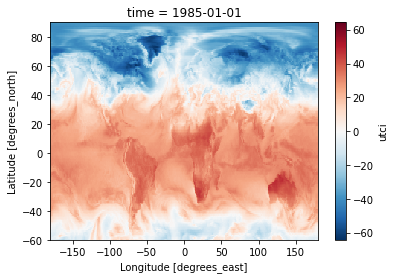

In [98]:
ds_e5h.isel(time=0).utci.plot()

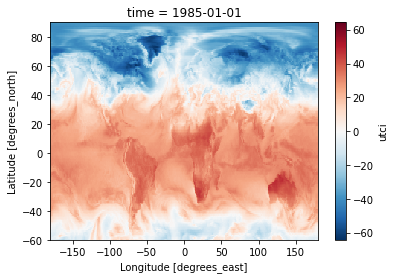

In [99]:
ds_e5h.isel(time=0).utci.plot()

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))


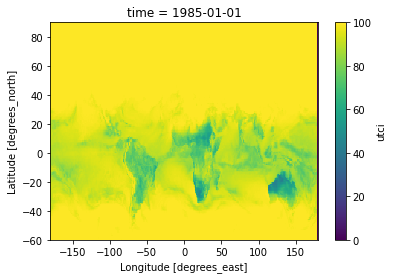

In [100]:
ds_e5h.isel(time=0).utci.pipe(valid_utci_to_pwc).plot()

In [101]:
# Population data
ds_gpw = (
    xr.open_dataset("/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc")
    .rename(latitude="lat", longitude="lon")
    .interp(lat=ds_e5h.lat, lon=ds_e5h.lon)
)
ds_gpw

<xarray.Dataset>
Dimensions:             (lat: 150, lon: 360)
Coordinates:
  * lat                 (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    population_density  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    latitude_longitude  int32 ...
Attributes:
    Conventions:  CF-1.5

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))


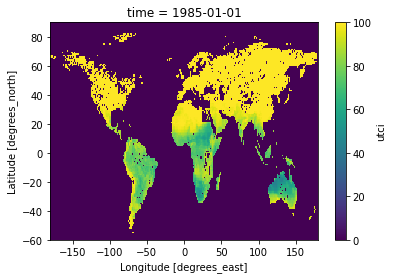

In [102]:
ds_e5h.isel(time=0).where(ds_gpw.population_density > 0).utci.pipe(
    valid_utci_to_pwc
).plot()

In [103]:
def pop_weighted_mean(x):
    return (
        x.fillna(0) * ds_gpw.population_density.fillna(0)
    ).mean() / ds_gpw.population_density.fillna(0).mean()

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


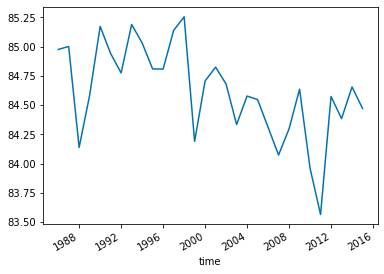

In [104]:
ds_e5h.utci.pipe(valid_utci_to_pwc).resample(time="Y").apply(pop_weighted_mean).plot()

## Step 2: Do the global calculation with monthly data for one model

In [16]:
import xarray as xr
from pathlib import Path
from pprint import PrettyPrinter as pp

gws_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/")

In [10]:
ls {gws_path}/utci_projections_1deg_monthly/HadGEM3-GC31-LL/

historical/  ssp126/  ssp245/  ssp585/


In [13]:
ls {gws_path}/utci_projections_1deg_monthly/HadGEM3-GC31-LL/historical/r1i1p1f3/monthly_avg.nc

/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/historical/r1i1p1f3/monthly_avg.nc


In [14]:
cmip_input_paths = list((gws_path / "utci_projections_1deg_monthly" / "HadGEM3-GC31-LL").glob("*/*/monthly_avg.nc"))
cmip_input_paths

[PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/historical/r1i1p1f3/monthly_avg.nc'),
 PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp126/r1i1p1f3/monthly_avg.nc'),
 PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp245/r1i1p1f3/monthly_avg.nc'),
 PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp585/r1i1p1f3/monthly_avg.nc')]

In [21]:
# Get the model name and scenario from the path name
model_names = []
scenario_names = []
for input_path in cmip_input_paths:
    model_names.append(str(input_path).split("/")[-4])
    scenario_names.append(str(input_path).split("/")[-3])
    
pp().pprint(list(zip(cmip_input_paths, model_names, scenario_names)))

[(PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/historical/r1i1p1f3/monthly_avg.nc'),
  'HadGEM3-GC31-LL',
  'historical'),
 (PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp126/r1i1p1f3/monthly_avg.nc'),
  'HadGEM3-GC31-LL',
  'ssp126'),
 (PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp245/r1i1p1f3/monthly_avg.nc'),
  'HadGEM3-GC31-LL',
  'ssp245'),
 (PosixPath('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/HadGEM3-GC31-LL/ssp585/r1i1p1f3/monthly_avg.nc'),
  'HadGEM3-GC31-LL',
  'ssp585')]


In [24]:
def valid_utci_to_pwc(utci):
    return utci_to_pwc(utci.where(utci > 15, 15).where(utci < 63, 63))

In [ ]:
for input_path in cmip_input_paths:
    # Load the data
    ds = xr.open_dataset(input_path)
    
    # Convert to celsius
    ds = ds - ABSOLUTE_ZERO
    
    # Calculate PWC
    ds["pwc"] = ds.utci.pipe(valid_utci_to_pwc)
    
    # Get average change map for present->2050->2100
    ds_2050 = ds.sel()
    
    # Weight by population and aggregate to country borders, getting averages for present->2050->2100
    
    ds.close()
    

In [27]:
def kelvin_to_celsius(T):
    return T - 273.15

In [42]:
import xarray as xr
from pathlib import Path
import numpy as np



utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))

ds_scenario_results = []
for model in model_list:
    print(model)
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((utci_path / model / "historical").glob("*/monthly_avg.nc"))[
        0
    ]
    ds_monthly = xr.open_dataset(monthly_path).pipe(kelvin_to_celsius)
    ds_monthly["pwc"] = ds_monthly.utci.pipe((valid_utci_to_pwc))

    
    ds_baseline = ds_monthly.sel(time=slice("1986", "2016")).groupby("time.month").mean("time")
    
    # Population data
    ds_gpw = (
        xr.open_dataset("/gws/pw/j05/cop26_hackathons/bristol/project10/SEDAC_GPW_2020.nc")
        .rename(latitude="lat", longitude="lon")
        .interp(lat=ds_baseline.lat, lon=ds_baseline.lon)
    )
    ds_gpw["mask"] = ds_gpw.population_density > 0
    
    
    ds_scenario_results.append([])

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        print("\t", scenario)
        if scenario == "historical":
            continue
        monthly_path = list((utci_path / model / scenario).glob("*/monthly_avg.nc"))[
            0
        ]
        ds_monthly = xr.open_dataset(monthly_path).pipe(kelvin_to_celsius)
        ds_monthly["pwc"] = ds_monthly.utci.pipe((valid_utci_to_pwc))

        ds_scenario_results[-1].append(
            (
                ds_monthly.sel(time=slice("2035", "2065")).groupby("time.month") - ds_baseline
            ).where(ds_gpw.mask).mean("time")
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2050])
        
        ds_scenario_results[-1].append(
            (
                ds_monthly.sel(time=slice("2070", "2100")).groupby("time.month") - ds_baseline
            ).where(ds_gpw.mask).mean("time")
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2085])

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])#, dim="scenario")
    ds_scenario_results[-1] = ds_scenario_results[-1].assign_coords(model=[model])
    

ds_scenario_results = xr.combine_by_coords(ds_scenario_results)#, dim="model")

HadGEM3-GC31-LL
	 historical
	 ssp126
	 ssp245
	 ssp585
BCC-CSM2-MR
	 historical
	 ssp126
	 ssp245
	 ssp585
CMCC-ESM2
	 historical
	 ssp126
	 ssp245
	 ssp585


In [43]:
ds_scenario_results.utci.attrs = {"long_name": "Change in UTCI", "short_name": "delta_utci", "units": "K"}
ds_scenario_results.pwc.attrs = {"long_name": "Change in PWC", "short_name": "delta_pwc", "units": "%"}

In [ ]:
# Plot the maps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

map_proj = ccrs.EqualEarth()

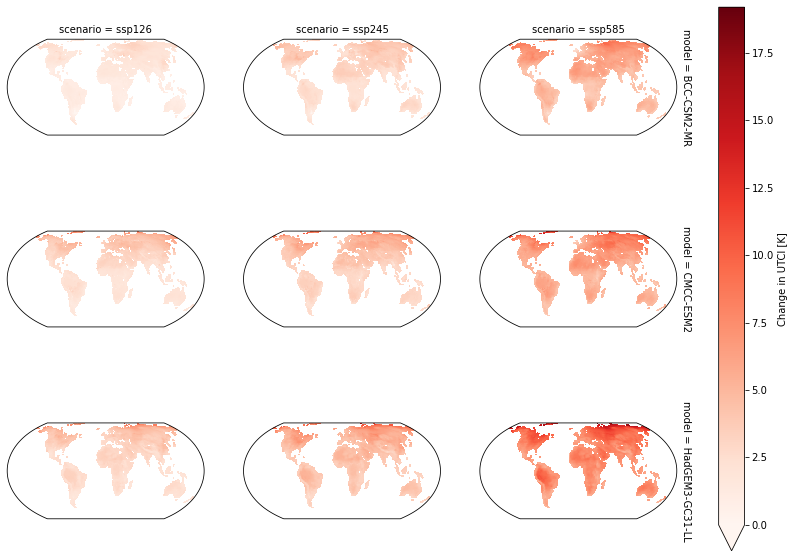

In [48]:
fg = ds_scenario_results.sel(year=[2085]).utci.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='Reds',
    vmin=0,
    row="model", 
    col="scenario",
)

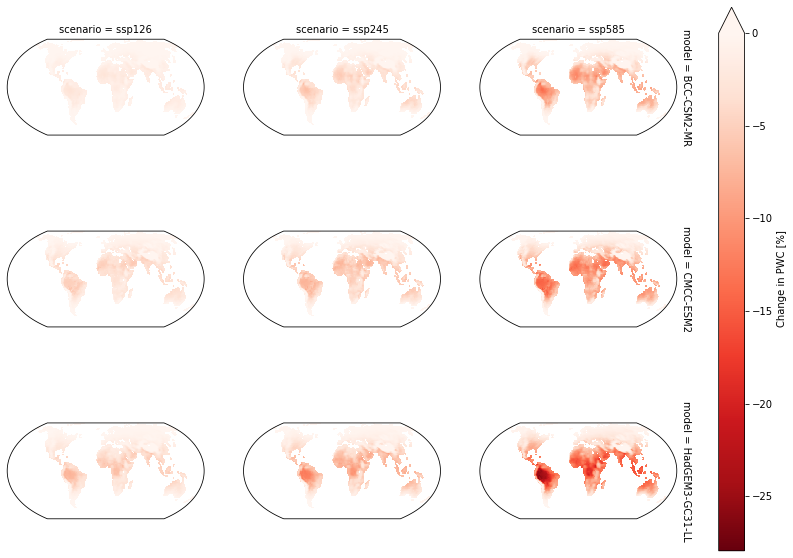

In [45]:
fg = ds_scenario_results.sel(year=[2085]).pwc.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='Reds_r',
    vmax=0,
    row="model", 
    col="scenario",
)


In [49]:
def population_weighting(x):
    return x * ds_gpw.population_density.fillna(0)

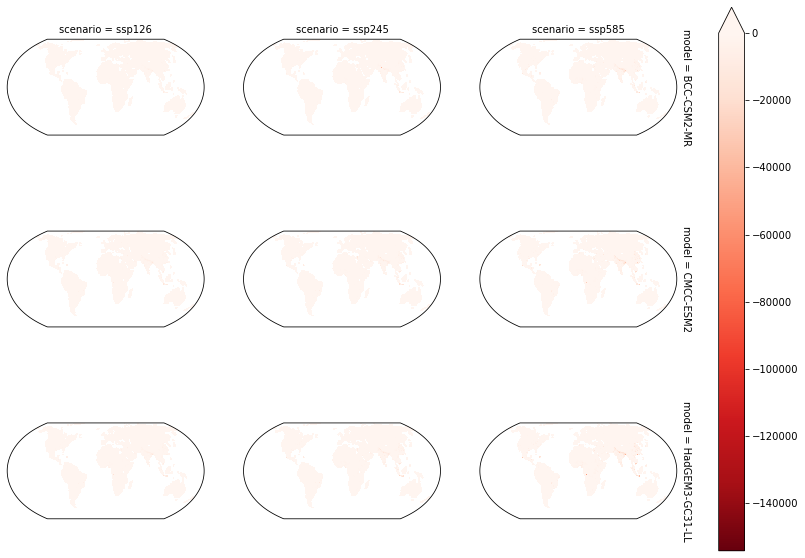

In [50]:
fg = ds_scenario_results.sel(year=[2085]).pwc.pipe(population_weighting).plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='Reds_r',
    vmax=0,
    row="model", 
    col="scenario",
)


Maps of person-hours lost are dominated by a few areas of very high population density.

Now I will aggregate these results to country borders.

In [51]:
import regionmask

In [53]:
regionmask.defined_regions.natural_earth?

In [54]:
# I will use countries_110, but we could also go to 1st admin level if appropriate
regions = regionmask.defined_regions.natural_earth.countries_110

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [85]:
ds = ds_scenario_results
mask = regions.mask(ds.lon, ds.lat)
mask_regions = xr.concat([(mask == r.number) for r in regions], dim="region")
mask_regions["region"] = [r.abbrev for r in regions] # fix 'coordinates'

In [105]:
def pop_weighted_mean(x, dims=("lat", "lon")):
    return (
        x.fillna(0) * ds_gpw.population_density.fillna(0)
    ).mean(dims) / ds_gpw.population_density.fillna(0).mean(dims)

In [106]:
ds_countries = ds.where(mask_regions).pipe(pop_weighted_mean)

In [107]:
ds_countries

<xarray.Dataset>
Dimensions:   (bnds: 2, model: 3, region: 177, scenario: 3, year: 2)
Coordinates:
  * scenario  (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * year      (year) int64 2050 2085
  * model     (model) object 'BCC-CSM2-MR' 'CMCC-ESM2' 'HadGEM3-GC31-LL'
  * region    (region) <U4 'FJ' 'TZ' 'WS' 'CA' 'US' ... 'RS' 'ME' 'KO' 'TT' 'SS'
Dimensions without coordinates: bnds
Data variables:
    utci      (model, year, scenario, region) float64 0.0 0.005583 ... 0.01344
    lat_bnds  (model, year, scenario, bnds, region) float64 0.0 ... -1.975e-16
    lon_bnds  (model, year, scenario, bnds, region) float64 0.0 ... -1.481e-16
    pwc       (model, year, scenario, region) float64 0.0 -0.003638 ... -0.02947

In [108]:
df_countries = ds_countries[["utci", "pwc"]].to_dataframe().reset_index()
df_countries

,model,region,scenario,year,utci,pwc
0,BCC-CSM2-MR,FJ,ssp126,2050,0.000000,0.000000
1,BCC-CSM2-MR,FJ,ssp126,2085,0.000000,0.000000
2,BCC-CSM2-MR,FJ,ssp245,2050,0.000000,0.000000
3,BCC-CSM2-MR,FJ,ssp245,2085,0.000000,0.000000
4,BCC-CSM2-MR,FJ,ssp585,2050,0.000000,0.000000
...,...,...,...,...,...,...
3181,HadGEM3-GC31-LL,SS,ssp126,2085,0.005060,-0.009532
3182,HadGEM3-GC31-LL,SS,ssp245,2050,0.004312,-0.008049
3183,HadGEM3-GC31-LL,SS,ssp245,2085,0.007034,-0.013862
3184,HadGEM3-GC31-LL,SS,ssp585,2050,0.006084,-0.011868


In [109]:
# Top twenty most affected countries
# In order of population weighted PWC decline.
# India and China are consistently the worst affected
df_countries.fillna(0).sort_values("pwc").head(20)

,model,region,scenario,year,utci,pwc
2717,HadGEM3-GC31-LL,IND,ssp585,2085,1.543637,-2.572338
1655,CMCC-ESM2,IND,ssp585,2085,1.189027,-2.039538
593,BCC-CSM2-MR,IND,ssp585,2085,1.072851,-1.494773
2963,HadGEM3-GC31-LL,CN,ssp585,2085,1.782480,-1.362838
2715,HadGEM3-GC31-LL,IND,ssp245,2085,0.859677,-1.290561
1653,CMCC-ESM2,IND,ssp245,2085,0.717213,-1.169813
2716,HadGEM3-GC31-LL,IND,ssp585,2050,0.688098,-1.045834
1901,CMCC-ESM2,CN,ssp585,2085,1.308730,-0.918907
2713,HadGEM3-GC31-LL,IND,ssp126,2085,0.621992,-0.875107
1654,CMCC-ESM2,IND,ssp585,2050,0.541112,-0.845318


* I've calculated this as an annual mean.
* It would make more sense to look at months or seasons separately.
* It would also make sense to look at the first admin level, because China and India are massively diverse geographically.